# <a id='toc1_'></a>[LSTM MODEL FOR TIME SERIES ANALYSIS](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [LSTM MODEL FOR TIME SERIES ANALYSIS](#toc1_)    
  - [Import Libraries](#toc1_1_)    
  - [Get Data](#toc1_2_)    
  - [Sliding Window & Preprocessing](#toc1_3_)    
  - [Define LSTM Model](#toc1_4_)    
  - [Define Model Training Parameters And Training](#toc1_5_)    
  - [Model Forecast Plot](#toc1_6_)    
  - [Learning Curves for Training and Validation Accuracy (200 Epochs) and all epochs](#toc1_7_)    
  - [Directional Predictive Accuracy](#toc1_8_)    
  - [Distribution of Residuals](#toc1_9_)    
  - [Summary of Metrics](#toc1_10_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Import Libraries](#toc0_)

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error
import LSTMpy as lstmm
## Import nessesary packages
import statsmodels.api as sm
import statsmodels.stats.diagnostic
from tabulate import tabulate
from scipy import stats

## import tabulate for latex table
from tabulate import tabulate

# Set seed for reproducability
np.random.seed(42)
torch.manual_seed(42)

% matplotlib inline
% load_ext autoreload

UsageError: Line magic function `%` not found.


## <a id='toc1_2_'></a>[Get Data](#toc0_)

In [64]:
## Get Data form RiksBanken
column = "SEK/DKK"

data = pd.read_csv("20_year_data.csv", delimiter=";")

data['Date'] = pd.to_datetime(data['Date'], format = '%d/%m/%Y')
data = data.set_index('Date')

data = data.replace(to_replace=",", value=".", regex=True)

## choose only the "Value" column with iloc
data = data.iloc[:, 2:3]

data

,Value
Date,
2003-05-02,0.815
2003-05-05,0.8173
2003-05-06,0.8173
2003-05-07,0.8173
2003-05-08,0.8153
...,...
2023-04-25,0.6592
2023-04-26,0.6573
2023-04-27,0.654


In [65]:
print(data.shape)

(5028, 1)


## <a id='toc1_3_'></a>[Sliding Window & Preprocessing](#toc0_)

In [66]:
seq_length = 30
train_ratio = 0.8
val_ratio = 0.1581
batch_size = 32

trainX, trainY, valX, valY, testX, testY, sc, train_size, val_size, test_size, y, data_normalized = lstmm.preprocessing(data, seq_length, train_ratio, val_ratio)

## <a id='toc1_4_'></a>[Define LSTM Model](#toc0_)

In [67]:
# LSTM model definition

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        ## Define the parameters
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.batch_size = batch_size

        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True
        )

        self.fc = nn.Linear(hidden_size, num_classes)

    # Define the forward pass
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)
        return out

## <a id='toc1_5_'></a>[Define Model Training Parameters And Training](#toc0_)

In [68]:
# Set seed for reproducability
np.random.seed(42)
torch.manual_seed(42)

# Model training
num_epochs = 7000
learning_rate = 0.001

# Set size of LSTM
input_size = 1
hidden_size = 50
num_layers = 1
num_classes = 1

# Initialize LSTM model
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

# Define loss function and optimizer (MSE and Adam)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
train_losses = []
val_losses = []


# Train the model (Back Propagation)
for epoch in (range(num_epochs)):
    # Training
    lstm.train()
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    # Validation
    lstm.eval()
    val_outputs = lstm(valX)
    val_loss = criterion(val_outputs, valY)

    # Save losses
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 100 == 0:
        print("Epoch: %d, Training Loss: %1.5f, Validation Loss: %1.5f" % (epoch, loss.item(), val_loss.item()))

       


Epoch: 0, Training Loss: 0.03708, Validation Loss: 0.02386
Epoch: 100, Training Loss: 0.02089, Validation Loss: 0.06804
Epoch: 200, Training Loss: 0.02017, Validation Loss: 0.06728
Epoch: 300, Training Loss: 0.01932, Validation Loss: 0.06435
Epoch: 400, Training Loss: 0.01835, Validation Loss: 0.06102
Epoch: 500, Training Loss: 0.01725, Validation Loss: 0.05727
Epoch: 600, Training Loss: 0.01602, Validation Loss: 0.05308
Epoch: 700, Training Loss: 0.01464, Validation Loss: 0.04842
Epoch: 800, Training Loss: 0.01315, Validation Loss: 0.04336
Epoch: 900, Training Loss: 0.01154, Validation Loss: 0.03795


## <a id='toc1_6_'></a>[Model Forecast Plot](#toc0_)

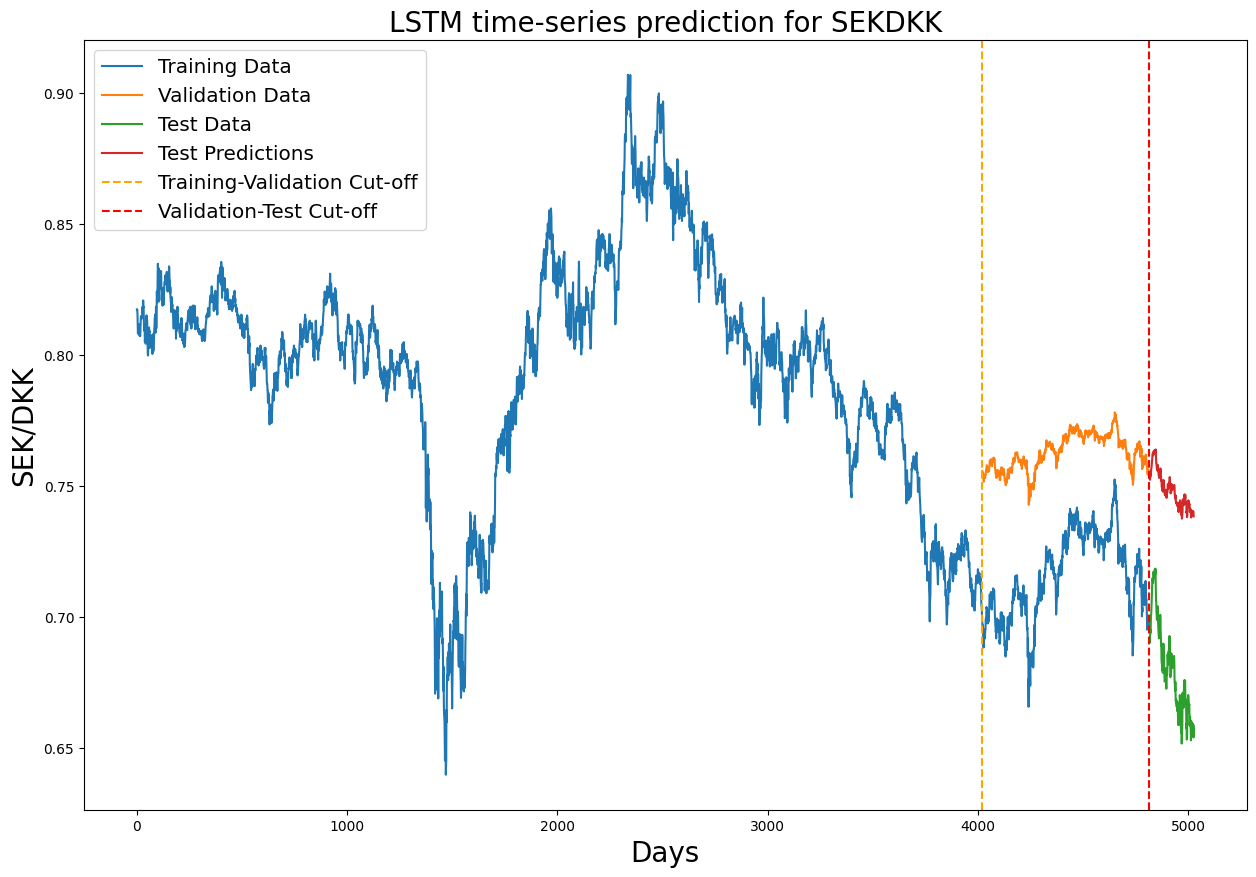

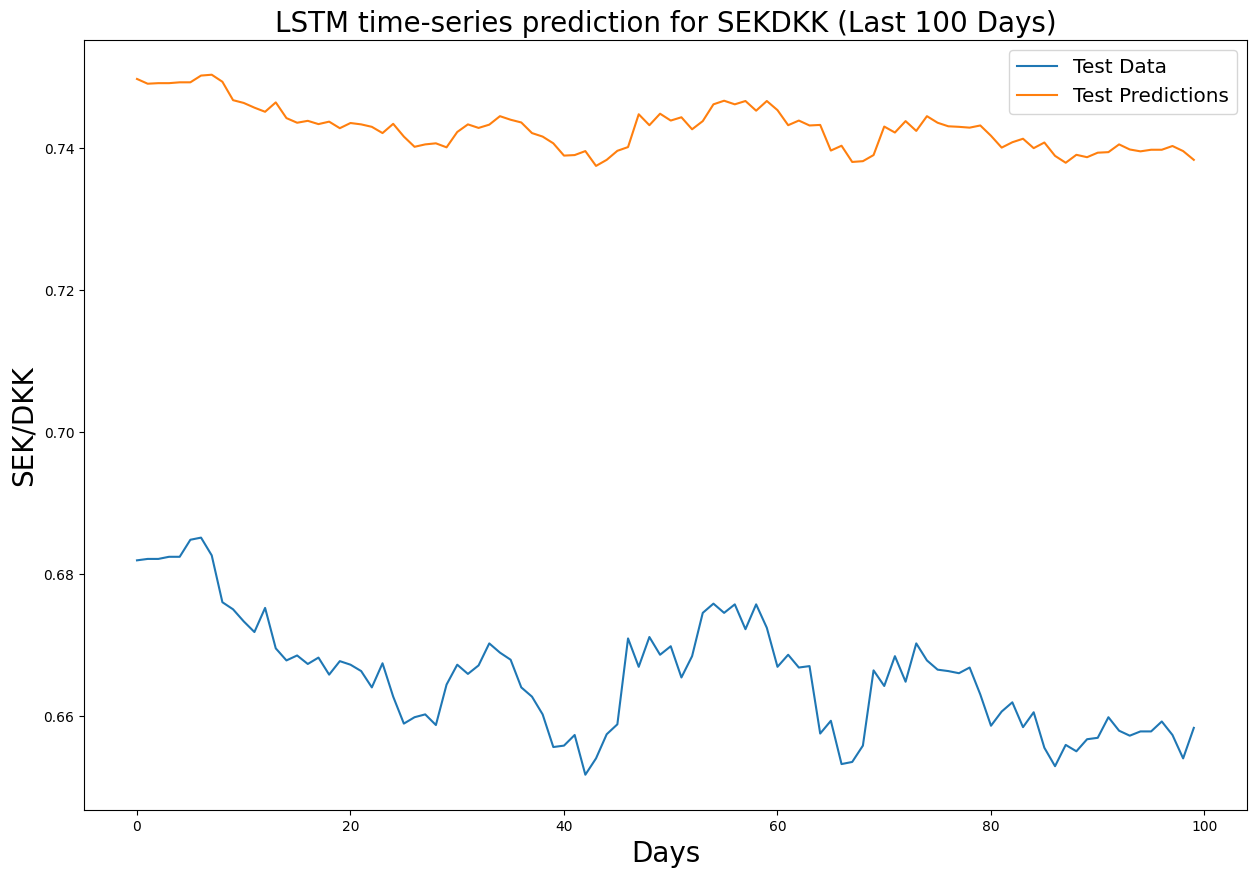

In [69]:
# Model evaluation

import LSTMpy as lstmm
import importlib
importlib.reload(lstmm)

# Iverse transform from MinMaxScaler to normal values
lstm.eval()
train_predict = lstm(torch.cat((trainX, valX)))
test_predict = lstm(testX)
train_predict = sc.inverse_transform(train_predict.data.numpy())
trainY_plot = sc.inverse_transform(torch.cat((trainY, valY)).data.numpy())
test_predict = sc.inverse_transform(test_predict.data.numpy())
testY_plot = sc.inverse_transform(testY.data.numpy())

lstmm.model_eval(trainY_plot, train_predict, testY_plot, test_predict, train_size, val_size, test_size)


In [70]:
# Calculate the error metrics
lstmm.metrics(testY_plot, test_predict)

Test MSE: 0.0048048124
Test R^2: -14.749429700890555
Test MAE: 0.0684801
Test Median AE: 0.0695225
Test MAPE: 0.101174384
\begin{tabular}{lr}
\hline
 Metric   &        Value \\
\hline
 R\^{}2      & -14.7494     \\
 MSE      &   0.00480481 \\
 MAE      &   0.0684801  \\
 MAPE     &   0.101174   \\
 RMSE     &   0.0693168  \\
\hline
\end{tabular}


## <a id='toc1_7_'></a>[Learning Curves for Training and Validation Accuracy (200 Epochs) and all epochs](#toc0_)

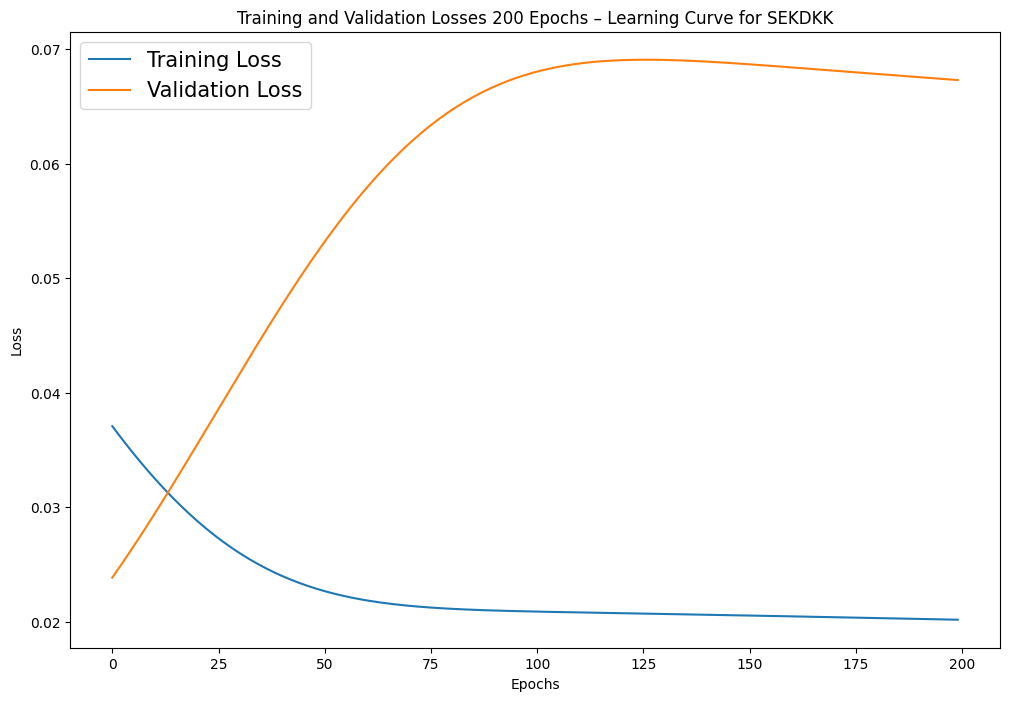

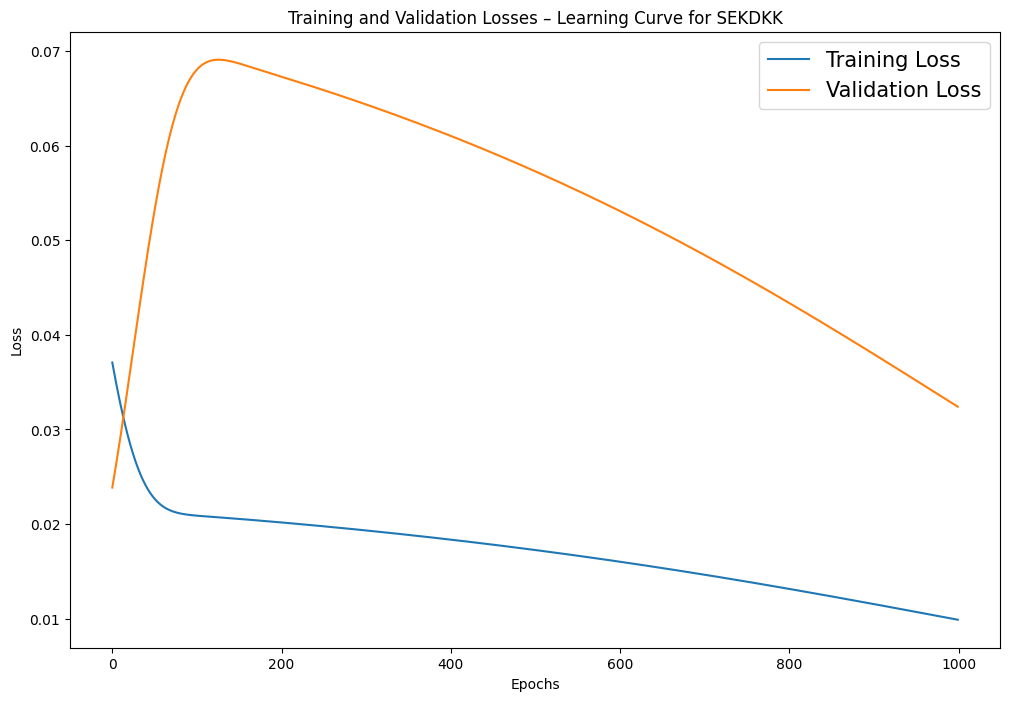

In [71]:
## Plots learning curves for all and 200 epochs
lstmm.plot_curve200(train_losses, val_losses)
lstmm.plot_curve_all(train_losses, val_losses)

## <a id='toc1_8_'></a>[Directional Predictive Accuracy](#toc0_)

In [72]:
# 
lstmm.DPA(testY_plot, test_predict)

Counter -7
Total number of predictions: 212
Number of correct directions: 102
Number of false directions: 109
Percentage of correct directions: 0.4811320754716981
Percentage of false directions: 0.5141509433962265
\begin{tabular}{lr}
\hline
                                  &   LSTM SEKDKK \\
\hline
 Counter                          &     -7        \\
 Total number of predictions      &    212        \\
 Number of correct directions     &    102        \\
 Number of false directions       &    109        \\
 Percentage of correct directions &      0.481132 \\
 Percentage of false directions   &      0.514151 \\
\hline
\end{tabular}


## <a id='toc1_9_'></a>[Distribution of Residuals](#toc0_)

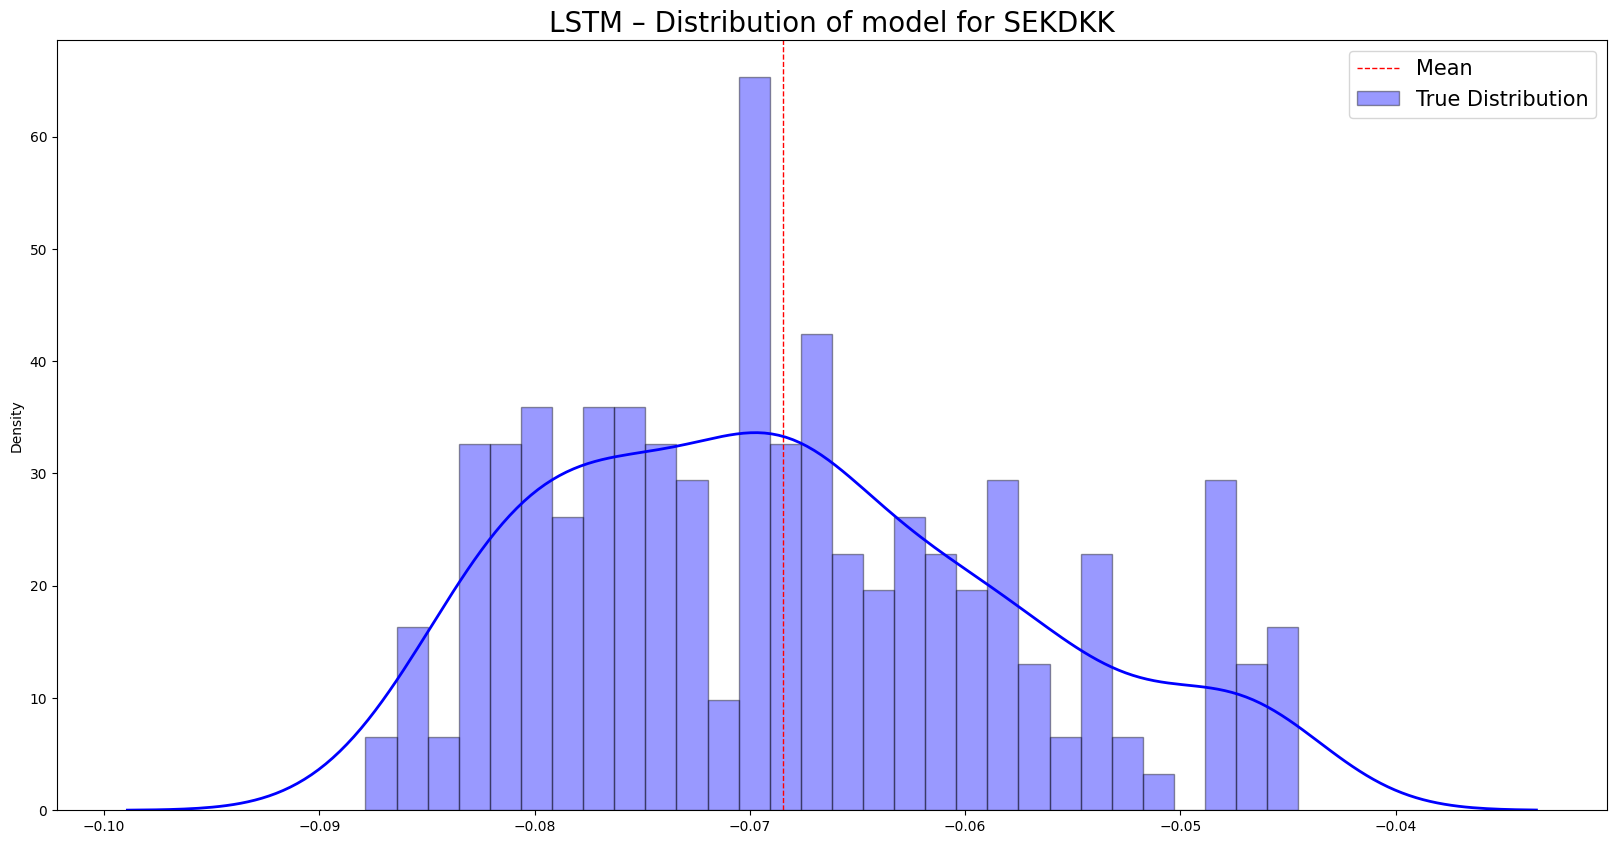

In [73]:
## Jarque-Bera test for normality of the residuals
## define residuals for the whole model
lstmm.dist(testY_plot, test_predict)

## <a id='toc1_10_'></a>[Summary of Metrics](#toc0_)

In [74]:
## Plot summary of the model along with white noise test, 
# ljung box test, 
# heteroscedasticity and normality test in a latex table using tabulate

residuals = testY_plot - test_predict
lstmm.summary_table(testY_plot, test_predict, residuals)

\begin{tabular}{lr}
\hline
 Summary LSTM – SEKDKK   &          Value \\
\hline
 Mean                    &  -0.0684801    \\
 Standard Error          &   0.0107373    \\
 Skewness                &   0.423091     \\
 Kurtosis                &  -0.629452     \\
 Jarque-Bera test        &   9.8247       \\
 p-value                 &   0.00735517   \\
 Ljung-Box test          & 897.289        \\
 p-value                 &   1.02785e-191 \\
 Heteroscedasticity      & 183.721        \\
 p-value                 &   3.95242e-34  \\
 Normality               &  12.8058       \\
 p-value                 &   0.00165671   \\
\hline
\end{tabular}
